# Only Plotting
This notebook compares the 6550 iterations trained polyhedral model with the trained model from the paper

In [1]:
import os
import torch

# Import our module containing helper functions
import gravann.polyhedral

# plotting stuff
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ", device)

C:\Users\josch\miniconda3\envs\geodesynet\lib\site-packages\pyvista\themes.py:131: PyVistaDeprecationWarning: use "dark" instead of "night" theme
  warnings.warn('use "dark" instead of "night" theme', PyVistaDeprecationWarning)


Available devices  1
__pyTorch VERSION: 1.13.1
__CUDNN VERSION: 8500
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


We first chose one of the following samples:

    "eros", "bennu", "itokawa", "churyumov-gerasimenko", "planetesimal", "torus", "bennu_nu", "itokawa_nu", "planetesimal_nu"

In [2]:
##################### PLEASE SPECIFY THIS ####################
# one of "eros", "bennu", "itokawa", "churyumov-gerasimenko", "planetesimal", "torus", "bennu_nu", "itokawa_nu", "planetesimal_nu"
SAMPLE_NAME = "churyumov-gerasimenko"
# can be freely chosen
MODEL_NAME = "third"

N_QUADRATUR = 30000

# Plotting
NUMBER_OF_POINTS_FOR_COMPARISON = 1000

# Real Math Stuff
NUMBER_OF_POINTS_FOR_VALIDATION = 10000
SAMPLING_ALTITUDES = [1e-5, 1e-3, 1e-1]

BATCH_SIZE = 100
##############################################################

MODEL_FILENAME_MASCON = f"models/{SAMPLE_NAME}.mdl"
MODEL_FILENAME_POLYHEDRAL = f"models_polyhedral/{SAMPLE_NAME}_polyhedral_{MODEL_NAME}.mdl"



# Re-specify the encoding if another encoding was used for training!
encoding = gravann.direct_encoding()

mesh_vertices, mesh_faces = gravann.load_polyhedral_mesh(SAMPLE_NAME)
density = gravann.polyhedral.calculate_density(mesh_vertices, mesh_faces)

# Only for the legacy plots required
mascon_points, mascon_masses = gravann.load_mascon_data(SAMPLE_NAME)

print(f"Chosen body: {SAMPLE_NAME}")
print(f"Loaded Polyhedral Mesh Data:")
print(f"Loaded the Mesh of {SAMPLE_NAME}")
print(f"Number of vertices: {len(mesh_vertices)}")
print(f"Number of faces (triangles): {len(mesh_faces)}")
print(f"Calculated Density: {density}")
print(f"Number of Mascons: {len(mascon_points)}")

Chosen body: churyumov-gerasimenko
Loaded Polyhedral Mesh Data:
Loaded the Mesh of churyumov-gerasimenko
Number of vertices: 9149
Number of faces (triangles): 18294
Calculated Density: 1.6605502606980964
Number of Mascons: 43599


## 0 - Comparing polyhedral model & mascon model
Next, we can plot a comparison between the polyhedral gravity model's labels and the mascon labels:

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.
Splitting in left / right hemisphere
Left:  453  points.
Right:  547  points.


<IPython.core.display.Javascript object>


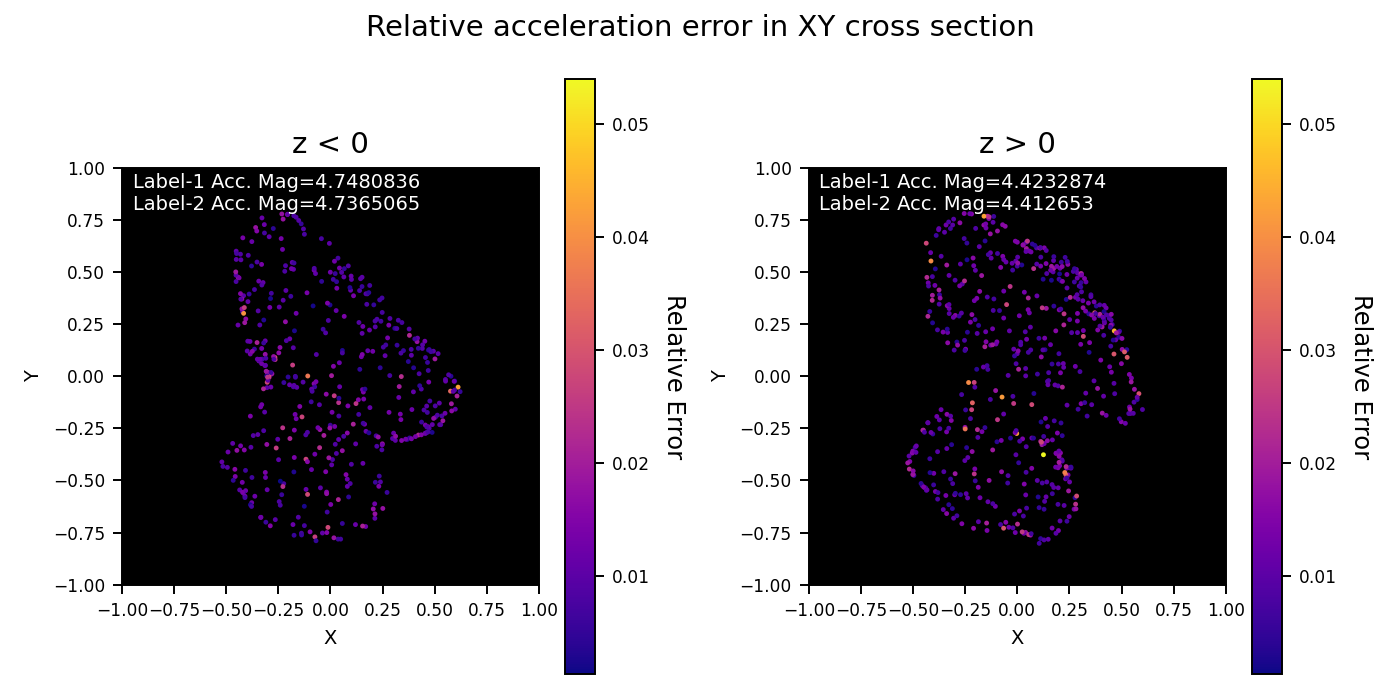

(<AxesSubplot: title={'center': 'z > 0'}, xlabel='X', ylabel='Y'>,
 tensor([[-1.9906, -2.6181,  0.3099],
         [-2.6959, -0.4743, -1.6680],
         [ 2.9141,  0.1473,  0.1070],
         ...,
         [-2.7838, -1.8523,  0.2867],
         [ 1.7826,  0.5132, -2.0156],
         [-2.0802, -1.4212, -1.6379]]))

In [3]:
gravann.polyhedral.plot_compare_acceleration(SAMPLE_NAME,
                                             compare_mode=('mascon', 'polyhedral'),
                                             plane="XY",
                                             N=NUMBER_OF_POINTS_FOR_COMPARISON,
                                             logscale=False,
                                             altitude=1e-5)

## 1 - Loading the models

C:\Users\josch\miniconda3\envs\geodesynet\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Sampling points...: 1080it [00:00, 2632.30it/s]                                                                        


<IPython.core.display.Javascript object>


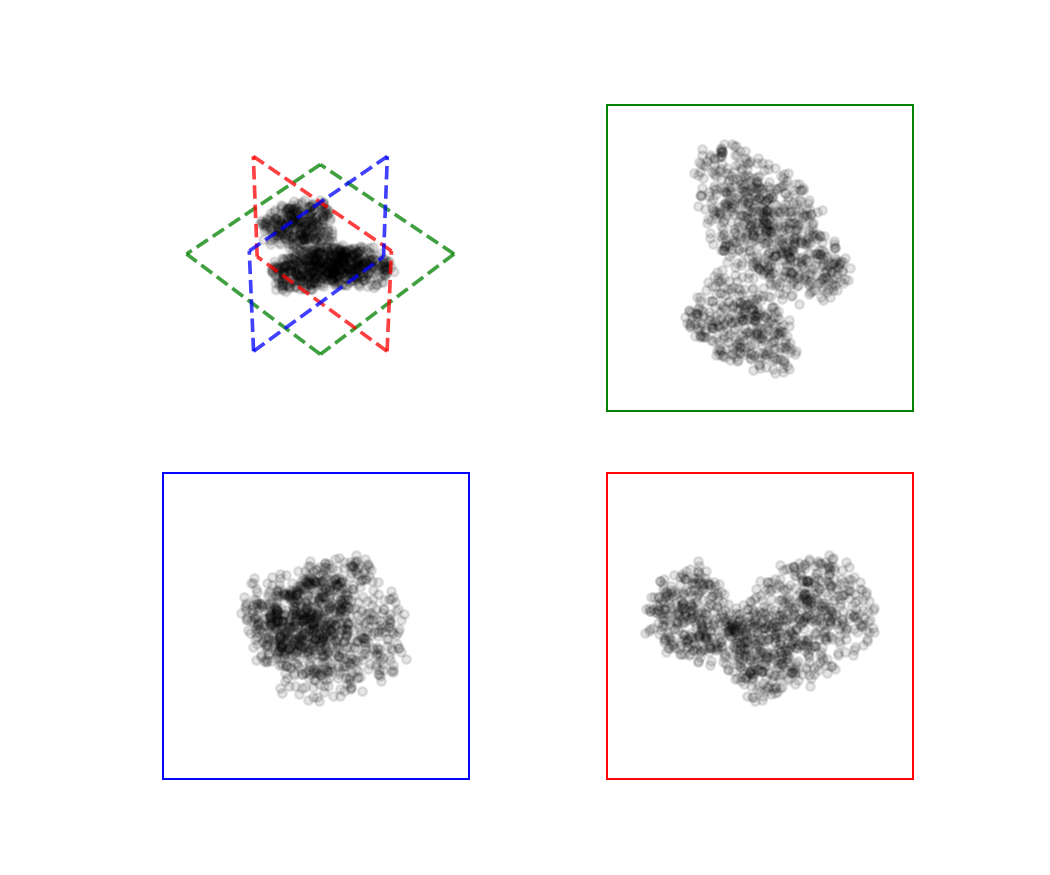

<IPython.core.display.Javascript object>


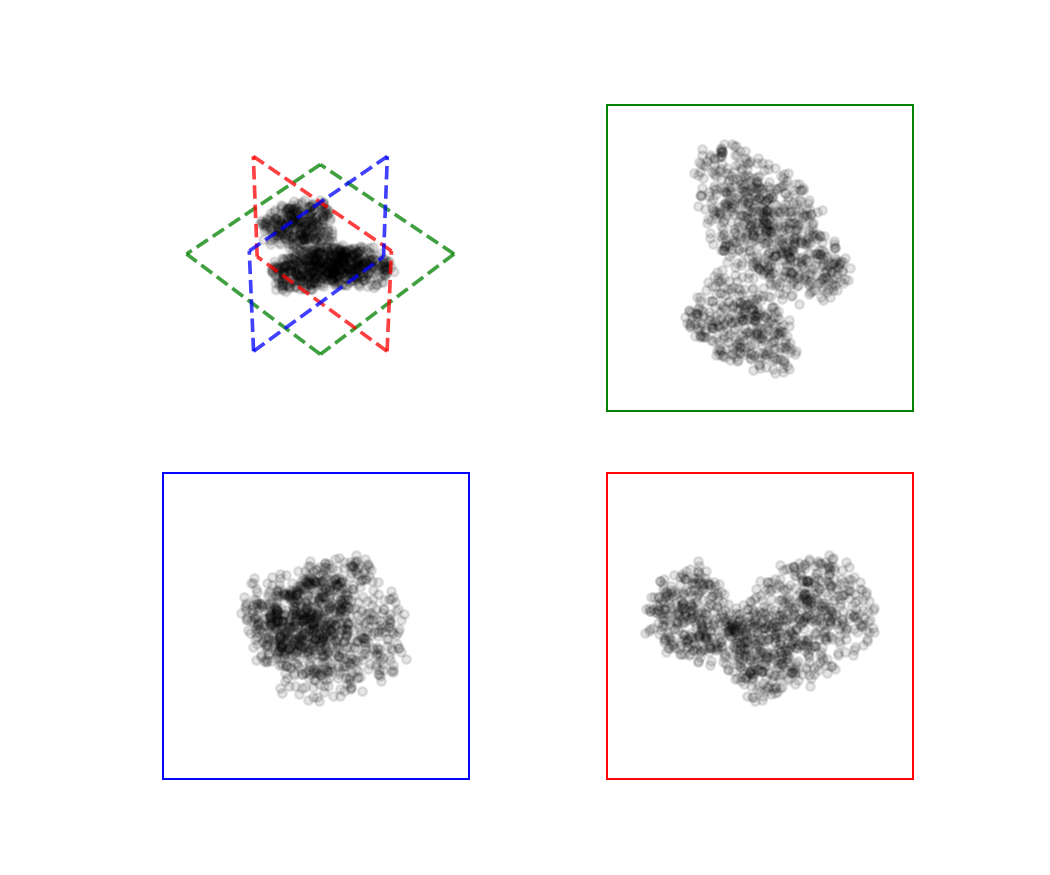

In [4]:
# POLYHEDRAL MODEL
polyhedral_model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.AbsLayer())

polyhedral_model.load_state_dict(torch.load(MODEL_FILENAME_POLYHEDRAL))

polyhedral_c = gravann.compute_c_for_model_v2(polyhedral_model, encoding, 'polyhedral',
                                              mascon_points=mascon_points,
                                              mascon_masses=mascon_masses,
                                              mesh_vertices=mesh_vertices,
                                              mesh_faces=mesh_faces,
                                              density=density,
                                              use_acc = True)
gravann.plot_model_rejection(polyhedral_model, encoding, views_2d=True, bw=True, N=NUMBER_OF_POINTS_FOR_COMPARISON, alpha=0.1, s=50, c=polyhedral_c, crop_p=0.1, progressbar=True)

Sampling points...: 1188it [00:00, 2972.78it/s]                                                                        


<IPython.core.display.Javascript object>


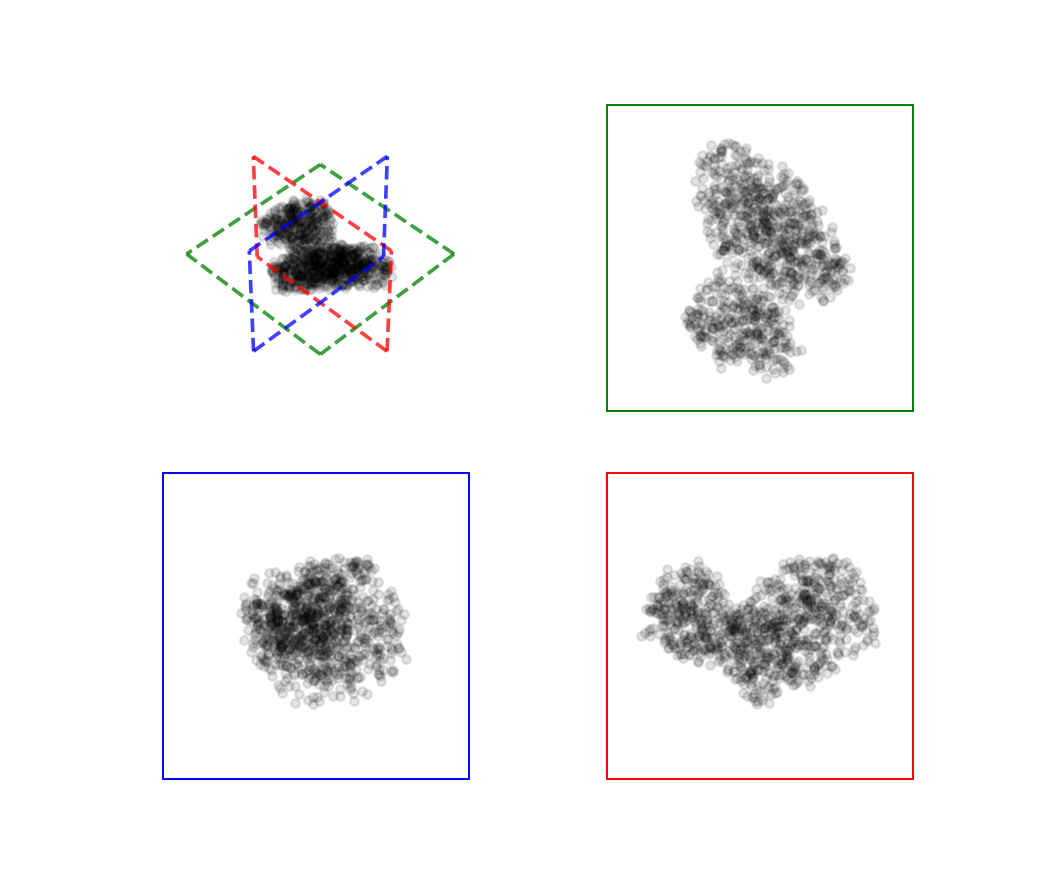

<IPython.core.display.Javascript object>


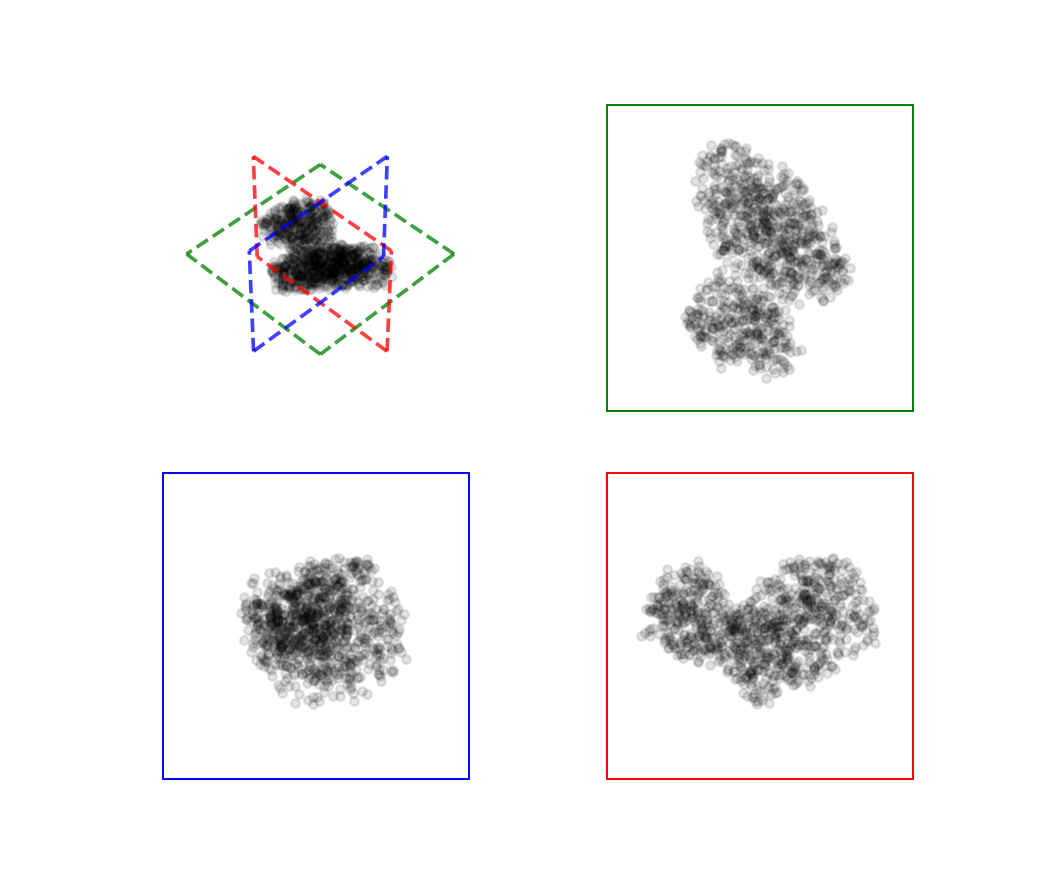

In [5]:
# MASCON MODEL
mascon_model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.AbsLayer())

mascon_model.load_state_dict(torch.load(MODEL_FILENAME_MASCON))

mascon_c = gravann.compute_c_for_model_v2(mascon_model, encoding, 'mascon',
                                          mascon_points=mascon_points,
                                          mascon_masses=mascon_masses,
                                          mesh_vertices=mesh_vertices,
                                          mesh_faces=mesh_faces,
                                          density=density,
                                          use_acc = True)
gravann.plot_model_rejection(mascon_model, encoding, views_2d=True, bw=True, N=NUMBER_OF_POINTS_FOR_COMPARISON, alpha=0.1, s=50, c=mascon_c, crop_p=0.1, progressbar=True)

## 2 - Comparing Polyhedral Model to the Polyhedral Ground Truth

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.
Splitting in left / right hemisphere
Left:  463  points.
Right:  537  points.


<IPython.core.display.Javascript object>


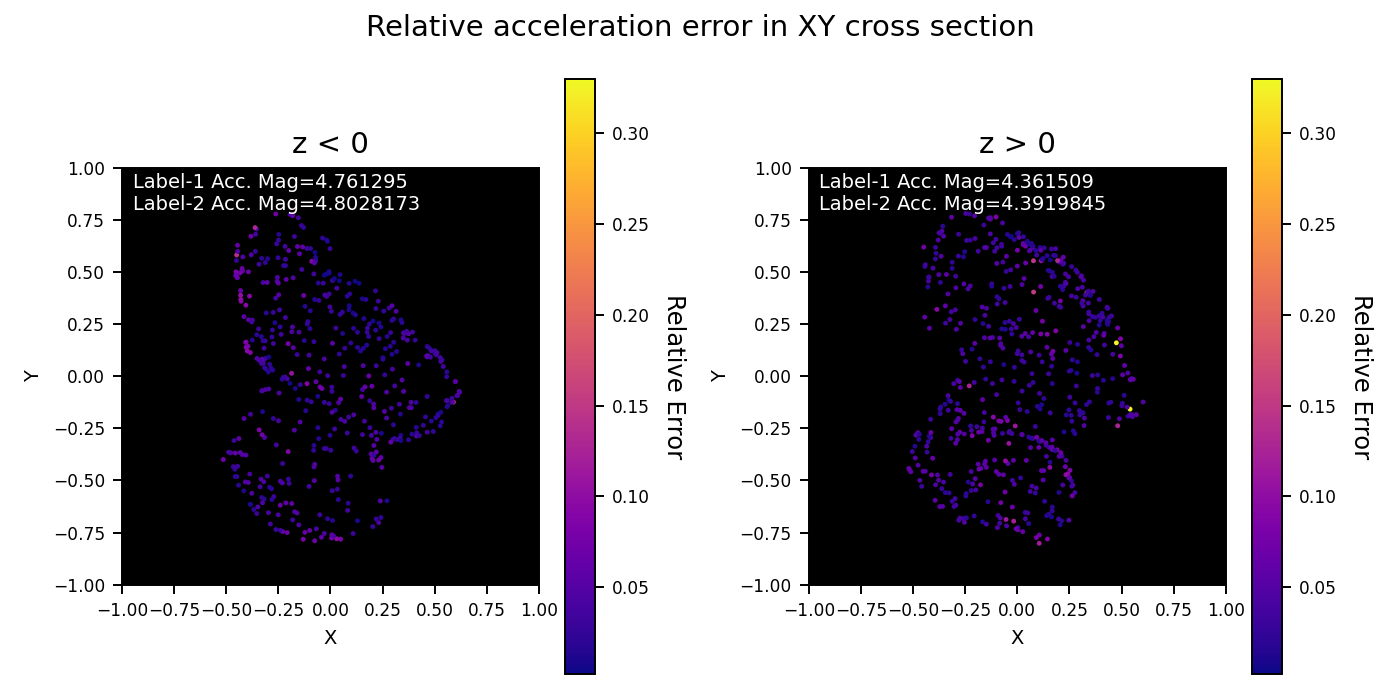

(<AxesSubplot: title={'center': 'z > 0'}, xlabel='X', ylabel='Y'>,
 tensor([[-3.2553, -0.5623, -0.5085],
         [ 0.4537, -2.0925, -2.0614],
         [-0.8735, -1.0351, -2.6669],
         ...,
         [ 1.8200, -2.2925, -0.5043],
         [ 1.3248,  0.4643, -2.7494],
         [ 0.4554, -2.2755, -1.9220]]))

In [6]:
gravann.polyhedral.plot_compare_acceleration(SAMPLE_NAME,
                                             compare_mode=('model', 'polyhedral'),
                                             model_1=(polyhedral_model, encoding, polyhedral_c),
                                             plane="XY",
                                             N=NUMBER_OF_POINTS_FOR_COMPARISON,
                                             logscale=False,
                                             altitude=1e-5)

In [7]:
polyhedral_model2polyhedral_gt = gravann.validation_v2(polyhedral_model, encoding, SAMPLE_NAME, 'polyhedral', use_acc=True,
                mesh_vertices=mesh_vertices,
                mesh_faces=mesh_faces,
                N=NUMBER_OF_POINTS_FOR_VALIDATION,
                N_integration=N_QUADRATUR,
                batch_size=BATCH_SIZE,
                sampling_altitudes=SAMPLING_ALTITUDES,
                progressbar=True)

Computing validation...:  65%|████████████████████████████████▍                 | 55000/84894 [02:26<01:08, 437.99it/s]

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...:  77%|██████████████████████████████████████▎           | 65000/84894 [03:19<00:57, 346.14it/s]

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...:  88%|████████████████████████████████████████████▏     | 75000/84894 [04:13<00:31, 318.74it/s]

Discarding 8598 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...: 85000it [04:57, 286.09it/s]                                                                   


In [8]:
polyhedral_model2polyhedral_gt

,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.039971,0.042429,0.268238,0.098564
1,High Altitude,0.033866,0.043990,0.513634,0.204645
2,Altitude_0,0.069698,0.069460,0.294516,0.098413
3,Altitude_1,0.067177,0.067191,0.294628,0.098358
4,Altitude_2,0.003165,0.004261,0.012299,0.005546


## 3 - Comparing Polyhedral Model to the Mascon Ground Truth

In [9]:
polyhedral_model2mascon_gt = gravann.validation_v2(polyhedral_model, encoding, SAMPLE_NAME, 'mascon', use_acc=True,
                mascon_points=mascon_points,
                mascon_masses=mascon_masses,
                N=NUMBER_OF_POINTS_FOR_VALIDATION,
                N_integration=N_QUADRATUR,
                batch_size=BATCH_SIZE,
                sampling_altitudes=SAMPLING_ALTITUDES,
                progressbar=True)

Computing validation...:  65%|███████████████████████████████▋                 | 55000/84894 [00:52<00:26, 1141.21it/s]

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...:  77%|██████████████████████████████████████▎           | 65000/84894 [01:29<00:24, 811.23it/s]

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...:  88%|████████████████████████████████████████████▏     | 75000/84894 [02:05<00:12, 812.20it/s]

Discarding 8598 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...: 85000it [02:32, 558.26it/s]                                                                   


In [10]:
polyhedral_model2mascon_gt

,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.042488,0.045010,0.353965,0.106949
1,High Altitude,0.036267,0.046422,0.566642,0.213653
2,Altitude_0,0.073455,0.072987,0.307399,0.101957
3,Altitude_1,0.070342,0.070105,0.286285,0.095494
4,Altitude_2,0.003442,0.004615,0.013544,0.006037


## 4 - Comparing Mascon Model to the Mascon Ground Truth

In [11]:
mascon_model2mascon_gt = gravann.validation_v2(mascon_model, encoding, SAMPLE_NAME, 'mascon', use_acc=True,
                mascon_points=mascon_points,
                mascon_masses=mascon_masses,
                N=NUMBER_OF_POINTS_FOR_VALIDATION,
                N_integration=N_QUADRATUR,
                batch_size=BATCH_SIZE,
                sampling_altitudes=SAMPLING_ALTITUDES,
                progressbar=True)

Computing validation...:  65%|███████████████████████████████▋                 | 55000/84894 [00:52<00:26, 1148.55it/s]

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...:  77%|██████████████████████████████████████▎           | 65000/84894 [01:29<00:23, 854.86it/s]

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...:  88%|████████████████████████████████████████████▏     | 75000/84894 [02:05<00:12, 806.41it/s]

Discarding 8598 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...: 85000it [02:32, 557.13it/s]                                                                   


In [12]:
mascon_model2mascon_gt

,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.071091,0.075585,0.608344,0.208513
1,High Altitude,0.049951,0.064069,0.698943,0.268613
2,Altitude_0,0.119815,0.119449,0.596337,0.199472
3,Altitude_1,0.112037,0.112167,0.550492,0.184926
4,Altitude_2,0.009505,0.012795,0.031640,0.014233


## 5 - Comparing Mascon Model to the Polyhedral Ground Truth

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.
Splitting in left / right hemisphere
Left:  459  points.
Right:  541  points.


<IPython.core.display.Javascript object>


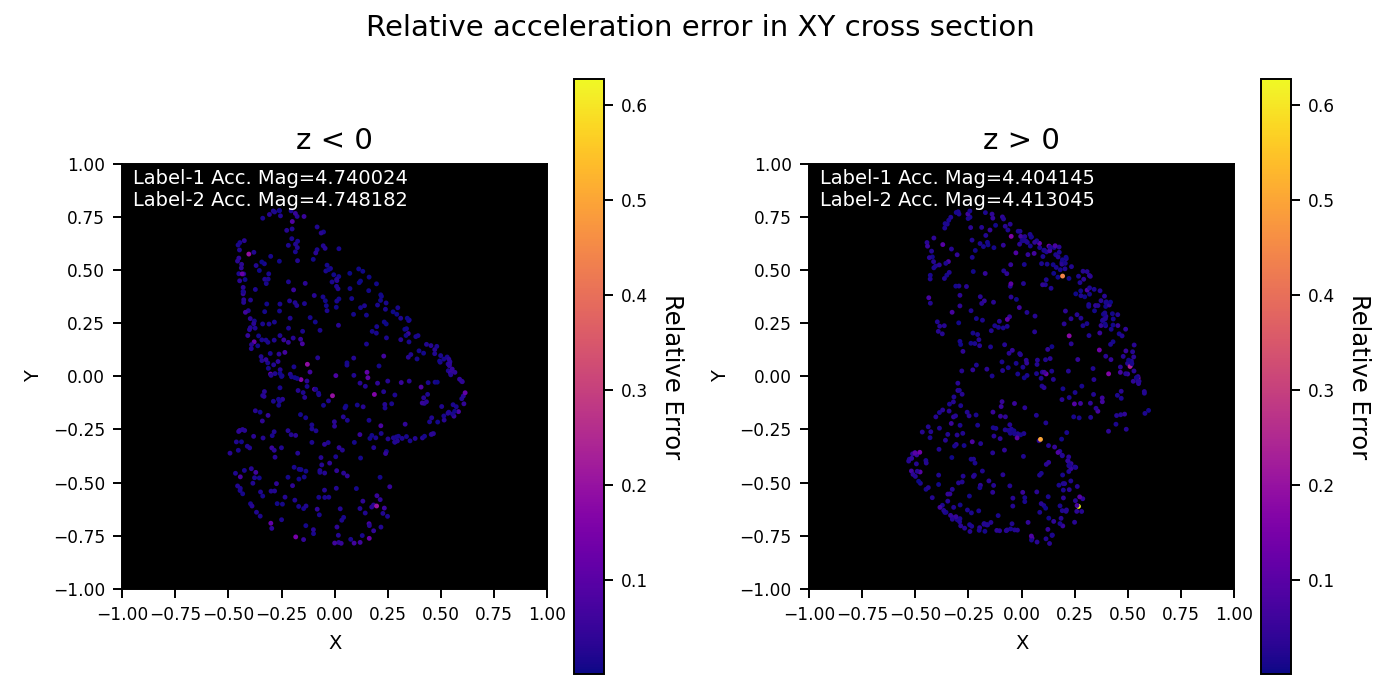

(<AxesSubplot: title={'center': 'z > 0'}, xlabel='X', ylabel='Y'>,
 tensor([[ 0.4932,  0.9768, -2.8145],
         [ 2.8024,  0.4802, -0.9278],
         [ 0.8842, -0.0419, -2.0905],
         ...,
         [-0.5064, -2.5131, -1.7272],
         [ 2.5444,  0.6988, -1.1725],
         [-1.5934,  1.2672, -2.1321]]))

In [13]:
gravann.polyhedral.plot_compare_acceleration(SAMPLE_NAME,
                                             compare_mode=('model', 'polyhedral'),
                                             model_1=(mascon_model, encoding, mascon_c),
                                             plane="XY",
                                             N=NUMBER_OF_POINTS_FOR_COMPARISON,
                                             logscale=False,
                                             altitude=1e-5)

In [14]:
mascon_model2polyhedral_gt = gravann.validation_v2(mascon_model, encoding, SAMPLE_NAME, 'polyhedral', use_acc=True,
                mesh_vertices=mesh_vertices,
                mesh_faces=mesh_faces,
                N=NUMBER_OF_POINTS_FOR_VALIDATION,
                N_integration=N_QUADRATUR,
                batch_size=BATCH_SIZE,
                sampling_altitudes=SAMPLING_ALTITUDES,
                progressbar=True)

Computing validation...:  65%|████████████████████████████████▍                 | 55000/84894 [02:25<01:10, 425.20it/s]

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...:  77%|██████████████████████████████████████▎           | 65000/84894 [03:18<01:00, 328.71it/s]

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...:  88%|████████████████████████████████████████████▏     | 75000/84894 [04:11<00:28, 353.09it/s]

Discarding 8598 of 18294 points in altitude sampler which did not meet requested altitude.


Computing validation...: 85000it [04:55, 287.44it/s]                                                                   


In [15]:
mascon_model2polyhedral_gt

,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.069050,0.073439,0.564889,0.204607
1,High Altitude,0.047631,0.061729,0.657333,0.259676
2,Altitude_0,0.118589,0.118489,0.595820,0.200544
3,Altitude_1,0.116768,0.116981,0.660872,0.224887
4,Altitude_2,0.009822,0.013166,0.032642,0.014603


## 6 - Comparing polyhedral trained NN & mascon trained NN

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.
Splitting in left / right hemisphere
Left:  461  points.
Right:  539  points.


<IPython.core.display.Javascript object>


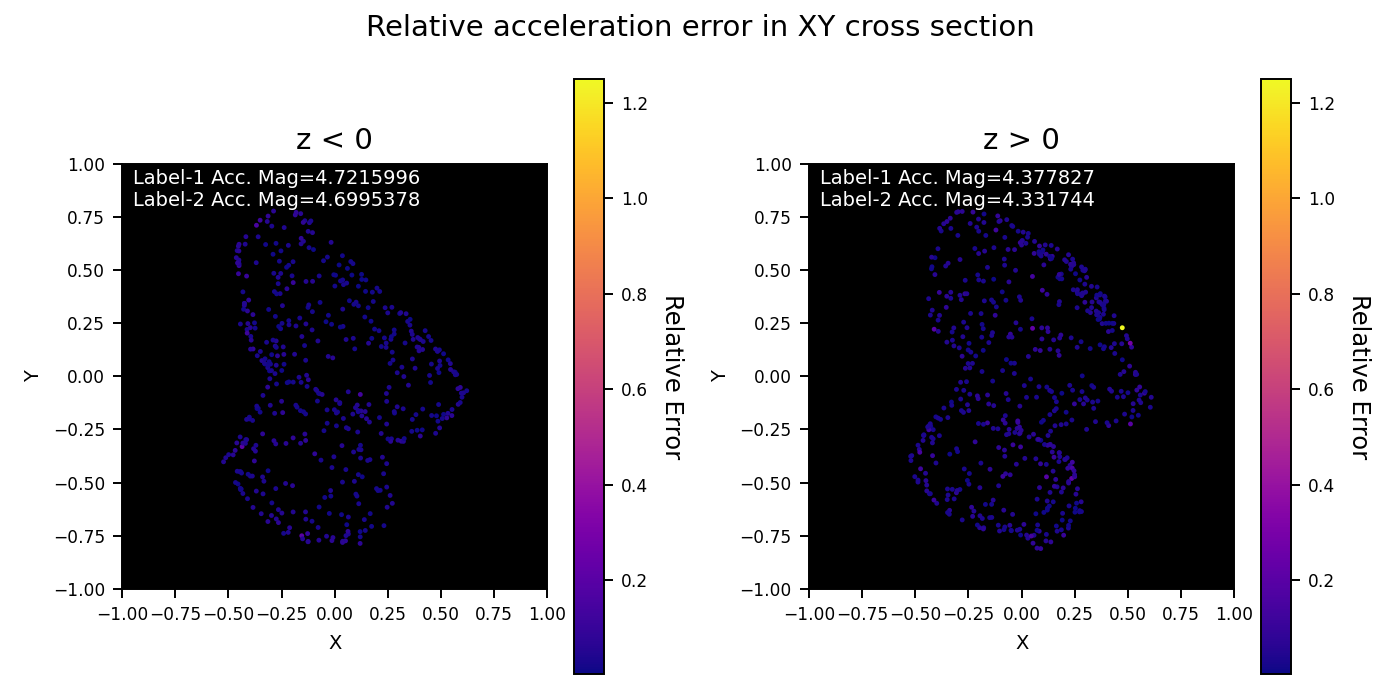

(<AxesSubplot: title={'center': 'z > 0'}, xlabel='X', ylabel='Y'>,
 tensor([[ 0.9465,  0.6167, -2.3891],
         [-0.7481,  0.2882, -2.6678],
         [ 2.7743,  0.5302, -0.8905],
         ...,
         [-1.5942, -2.6988, -0.1745],
         [-2.0567,  1.2123, -1.6812],
         [ 1.5280,  0.2792, -2.1054]]))

In [16]:
gravann.polyhedral.plot_compare_acceleration(SAMPLE_NAME,
                                             compare_mode=('model', 'model'),
                                             model_1=(mascon_model, encoding, mascon_c),
                                             model_2=(polyhedral_model, encoding, polyhedral_c),
                                             plane="XY",
                                             N=NUMBER_OF_POINTS_FOR_COMPARISON,
                                             logscale=False,
                                             altitude=1e-5)